

What's differentiate metric learning from traditional classification is that we train the model to learn a compact representation

how to have examples of the same classes to be close together and the one f


References
- Original paper:
FaceNet: A Unified Embedding for Face Recognition and Clustering
https://arxiv.org/abs/1503.03832 

- Mining strategies:
https://openaccess.thecvf.com/content_WACV_2020/papers/Xuan_Improved_Embeddings_with_Easy_Positive_Triplet_Mining_WACV_2020_paper.pdf 


In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [4]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.visualization import  viz_neigbors_imgs

In [5]:
tf_cap_memory()
print(tf.__version__)

2.3.1


# preparing data

Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [ ]:
# FIXME sampler here and select only half of the class

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

# keep only even digits
idxs = []
for idx in range(len(y_train)):
    if not y_train[idx] % 2:
        idxs.append(idx)
x_train_even = tf.gather(x_train, idxs)
y_train_even = tf.gather(y_train, idxs)
print(x_train.shape, y_train.shape)
print('x_train_even', x_train_even.shape, x_train_even.dtype)
print('y_train_even', y_train_even.shape, y_train_even.dtype)

(60000, 28, 28) (60000,)
x_train_even (29492, 28, 28) <dtype: 'float32'>
y_train_even (29492,) <dtype: 'uint8'>


# model creation

In [7]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = MetricEmbedding(10)(x)
    # outputs2 = MetricEmbedding(10)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)          

# Compilation

In [8]:

distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Training

In [16]:
model = get_model()
# model.compile(optimizer='adam', loss=triplet_loss)
history = model.compile(optimizer='adam', distance='cosine', loss=triplet_loss, run_eagerly=False)


EPOCHS = 5 #@param{Integer}
BATCH_SIZE = 32 #@param{Integer}
history = model.fit(x_train_even, y_train_even, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
922/922 [==============================] - 2s 2ms/step - loss: 0.2656 - val_loss: 0.7835
Epoch 2/5
922/922 [==============================] - 2s 2ms/step - loss: 0.0949 - val_loss: 0.8078
Epoch 3/5
922/922 [==============================] - 2s 2ms/step - loss: 0.0561 - val_loss: 0.7899
Epoch 4/5
922/922 [==============================] - 2s 2ms/step - loss: 0.0426 - val_loss: 0.7734
Epoch 5/5
922/922 [==============================] - 2s 2ms/step - loss: 0.0304 - val_loss: 0.7909


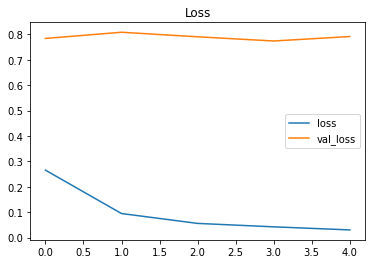

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

In [20]:
num_embeddings = 100
model.index(x_train[:num_embeddings], y_train[:num_embeddings])


In [21]:
# query the index for all the x_test at once
num_neighboors = 5
neighboors = model.lookup(x_test, k=num_neighboors)

In [23]:
# display results
display_id = 41
print('expected label: ', y_test[display_id])


lkp = model.single_lookup(x_test[display_id])
print([n['distance'] for n in lkp])

print('\n[Nearest embeddings]\n')
rows = [[n['label'], n['distance']] for n in neighboors[display_id]]
print(tabulate(rows, headers=['label', 'distances']))

expected label:  7
[0.0040937066, 0.0066340566, 0.0072357655, 0.00800091, 0.008759558]

[Nearest embeddings]

  label    distances
-------  -----------
      7   0.00409371
      2   0.00663406
      7   0.00723577
      2   0.00800091
      2   0.00875956


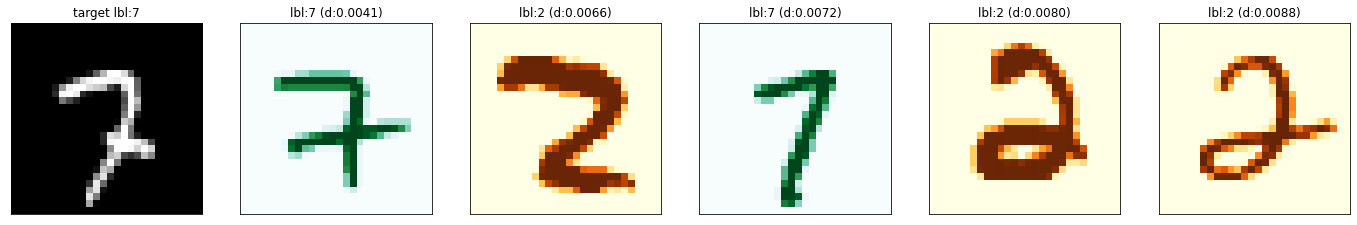

In [24]:
viz_neigbors_imgs(x_test[display_id], y_test[display_id], neighboors[display_id])

# Indexer stats

In [25]:
model.index_summary()

[Index statistics]
----------------  -----
query_time            0
query                 0
num_lookups       10002
num_items           100
stat_buffer_size    100
----------------  -----

[Query performance]
------  -----------
min     0
max     0.000500202
avg     9.35801e-06
median  4.44489e-06
stddev  4.93337e-05
------  -----------
